<a href="https://colab.research.google.com/github/anothersailor/webintro/blob/master/covidanalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mode d'emploi: 

Choisir le menu Exécution > Tout exécuter (cmd F9).

Après avoir changé le choix de pays ou de département, choisir Exécution > Exécuter à la suite (cmd F10)

# Initialisation

In [0]:
import os
import io
import requests

In [0]:
import datetime
from datetime import datetime as dtime
import time

In [0]:
import pandas as pd
import numpy as np
import scipy as sp
#import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
import ipywidgets
from ipywidgets import widgets, IntSlider

In [0]:
from bs4 import BeautifulSoup
import re
import zipfile as zip

### Fichier Monde

In [0]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.xlsx'

r = requests.get(url).content

In [32]:
df = pd.read_excel(r)
df['date'] = pd.to_datetime(df['date'])
rolling_wind = 7
df['new_deaths_per_million_rolling'] = df.new_deaths_per_million.rolling(window=rolling_wind).mean()
df['new_cases_per_million_rolling'] = df.new_cases_per_million.rolling(window=rolling_wind).mean()
df.head(5)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,new_deaths_per_million_rolling,new_cases_per_million_rolling
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Statistiques Monde

In [33]:
#@title
country_list = list(set(df['location']))
country_list.sort()
selection = widgets.SelectMultiple(
    options=country_list,
    value=['France', 'Spain', 'Italy', 'United Kingdom', 'Sweden', 'Germany', 'United States'],
    #rows=10,
    description='Countries:',
    disabled=False
)
display(selection)

SelectMultiple(description='Countries:', index=(68, 177, 98, 198, 182, 73, 199), options=('Afghanistan', 'Alba…

In [34]:
#@title
start = '2020-03-15'

date_start = pd.to_datetime(start)
sel = df[(df.location.isin(selection.value)) & (df.date > date_start)]
fig1 = px.line(sel, x="date", y="total_deaths_per_million", color="location")
fig1.update_layout(height= 800, title_text="Décès Covid, cumulés (par million d'habitants)")
fig1.show()

In [53]:
#@title
fig0 = px.line(sel, x='date', y='new_cases_per_million_rolling', color='location')
fig0.update_layout(height=800, title_text="Nouveaux cas par million, moyenne mobile 7 jours")
fig0.show()

In [36]:
#@title
fig2 = px.line(sel, x="date", y="new_deaths_per_million_rolling", color="location")
fig2.update_layout(height=800, title_text='Décès du jour CoVid, moyenne mobile 7 jours (par million d\'habitants)')
fig2.show()

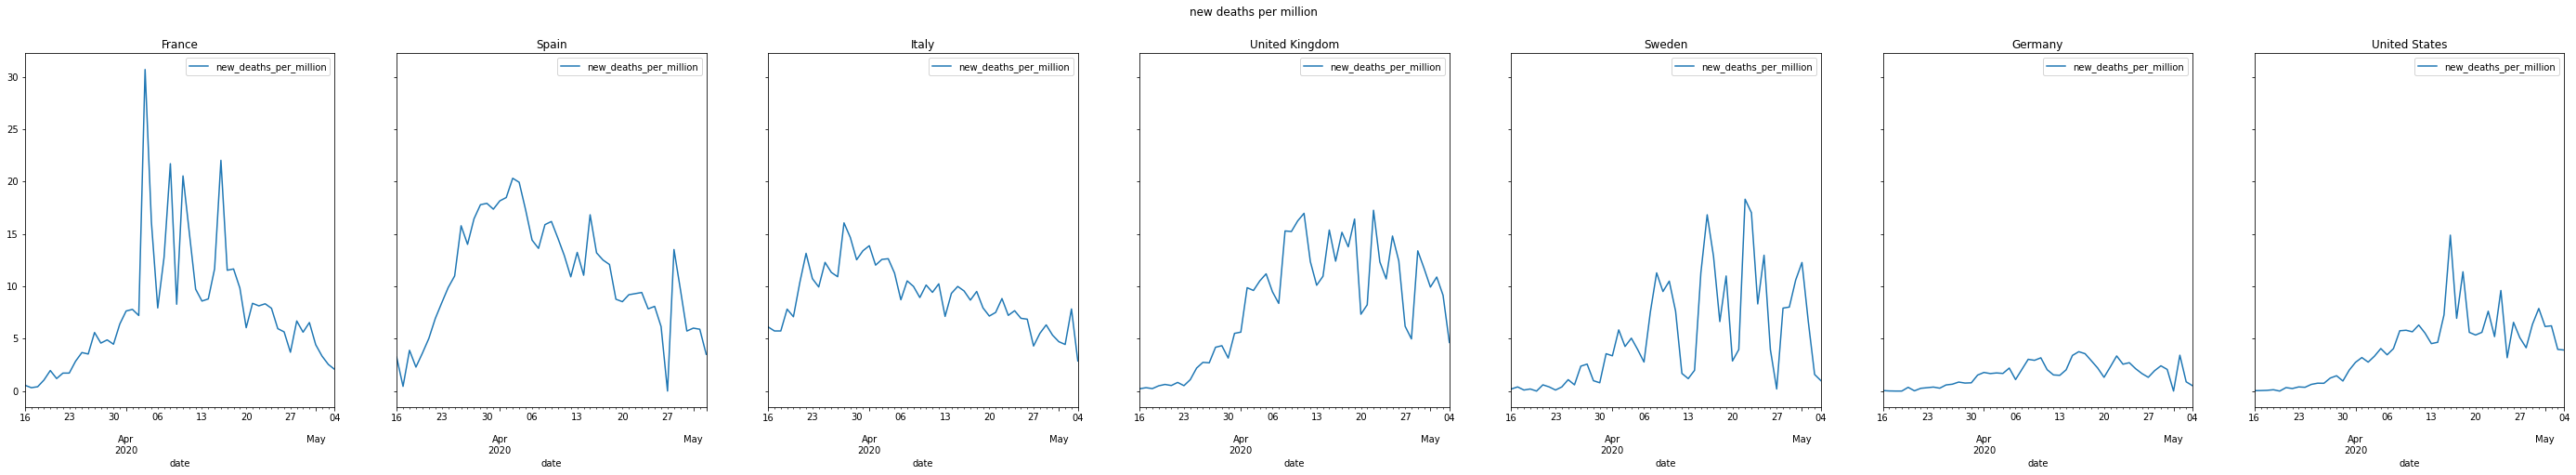

In [37]:
#@title
nbr_plots = len(selection.value)
fig, ax = plt.subplots(1, nbr_plots, figsize=(7 * nbr_plots, 7), sharey=True)
fig.suptitle('new deaths per million')
for i in range(nbr_plots):
    country = selection.value[i]
    ax[i].set_title(country)
    ax[i].tick_params('y')
    ax[i].grid(b=True, axis='y')
    sel[sel.location == country][['date', 'new_deaths_per_million']].plot(ax=ax[i], x='date')

### Fichiers DataGouv (Fce et départements)

In [38]:
start_pge = "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/"
page1 = requests.get(start_pge)
soup = BeautifulSoup(page1.content, 'html.parser')
#print(soup.prettify())
page1.status_code

200

In [0]:
list1 = soup.find(lambda tag: tag.name=="h4" and 'donnees-hospitalieres-covid19' in tag.text)


In [0]:
link1 = list1.parent.parent.find('a', href=True)
file1_url = link1['href']

In [41]:
#Hospital data
hd = pd.read_csv(file1_url, sep = ';')
hd.head(2)

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0


In [42]:
hd_FM = hd[hd.sexe == 0]
hd_FM.drop(columns=['sexe'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
hd_FM.loc[:, 'jour'] = pd.to_datetime(hd_FM.loc[:, 'jour'])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
#Computation deltas
hd_FM = hd_FM.sort_values(['dep', 'jour'])
for field in ['hosp', 'rea', 'rad', 'dc']:
    hd_FM['d'+field] = hd_FM.groupby('dep')[field].diff()

hd_FM = hd_FM.dropna(subset=['dhosp', 'drea', 'drad', 'ddc'])

### Adding the 2020 population by dept.

from google.colab import drive
drive.mount('/content/gdrive')
os.listdir('/content/gdrive')

In [0]:

url4 = 'https://www.insee.fr/fr/statistiques/fichier/1893198/estim-pop-dep-sexe-gca-1975-2020.xls'
r4 = requests.get(url4).content

In [0]:
dep_pop = pd.read_excel(r4, sheet_name = '2020', usecols=[0, 7], skiprows=4)
dep_pop.columns = ['dep', 'pop']
dep_pop = dep_pop.dropna()
dep_pop = dep_pop[~(dep_pop.dep.str.contains('France') | dep_pop.dep.str.contains('DOM') | dep_pop.dep.str.contains('Source'))]

In [0]:
hd_end = pd.merge(hd_FM, dep_pop, how='left', on="dep")

### Covid data:
* dep: département
* hosp: effectif en hospitalisation
* rea: effectif en réanimation
* rad: cumul retours à domicile
* dc: cumul décès
* dxxx: variation par rapport au jour précédent
* xxx_pM: valeurs par million d'hab du département
* pop: population du département (recens 2020)

In [48]:
hd_end2 = hd_end
for field in ['hosp', 'rea', 'rad', 'dc', 'dhosp', 'drea', 'drad', 'ddc']:
    hd_end2[field+'_pM'] = hd_end2[field] / hd_end2['pop'] * 1000000
hd_end2.head(2)

,dep,jour,hosp,rea,rad,dc,dhosp,drea,drad,ddc,pop,hosp_pM,rea_pM,rad_pM,dc_pM,dhosp_pM,drea_pM,drad_pM,ddc_pM
0,01,2020-03-19,2,0,1,0,0.0,0.0,0.0,0.0,656955.0,3.044349,0.0,1.522174,0.0,0.0,0.0,0.0,0.0
1,01,2020-03-20,2,0,1,0,0.0,0.0,0.0,0.0,656955.0,3.044349,0.0,1.522174,0.0,0.0,0.0,0.0,0.0


# Statistiques France

In [49]:
#@title
deps = list(set(hd_end2['dep']))
deps.sort()
dept_list = widgets.SelectMultiple(
    options = deps,
    value = ['56', '75', '06'],
    description = 'Départements',
    disabled = False
)
display(dept_list)

SelectMultiple(description='Départements', index=(56, 75, 5), options=('01', '02', '03', '04', '05', '06', '07…

In [50]:
#@title
sel_hd = hd_end[(hd_end.dep.isin(dept_list.value))]
fig3 = px.line(sel_hd, x="jour", y="ddc_pM", color="dep")
fig3.update_layout(height=800, title_text='Décès du jour en hopital (par million d\'habitants)')
fig3.show()

In [51]:
#@title
fig4=px.line(sel_hd, x="jour", y="dc_pM", color="dep")
fig4.update_layout(height=800, title_text='Décès cumulés en hopital (par million d\'habitants)')
fig4.show()

In [52]:
#@title
fig5=px.line(sel_hd, x="jour", y="rea", color="dep")
fig5.update_layout(height=800, title_text='Patients en réa (par million d\'habitants)')